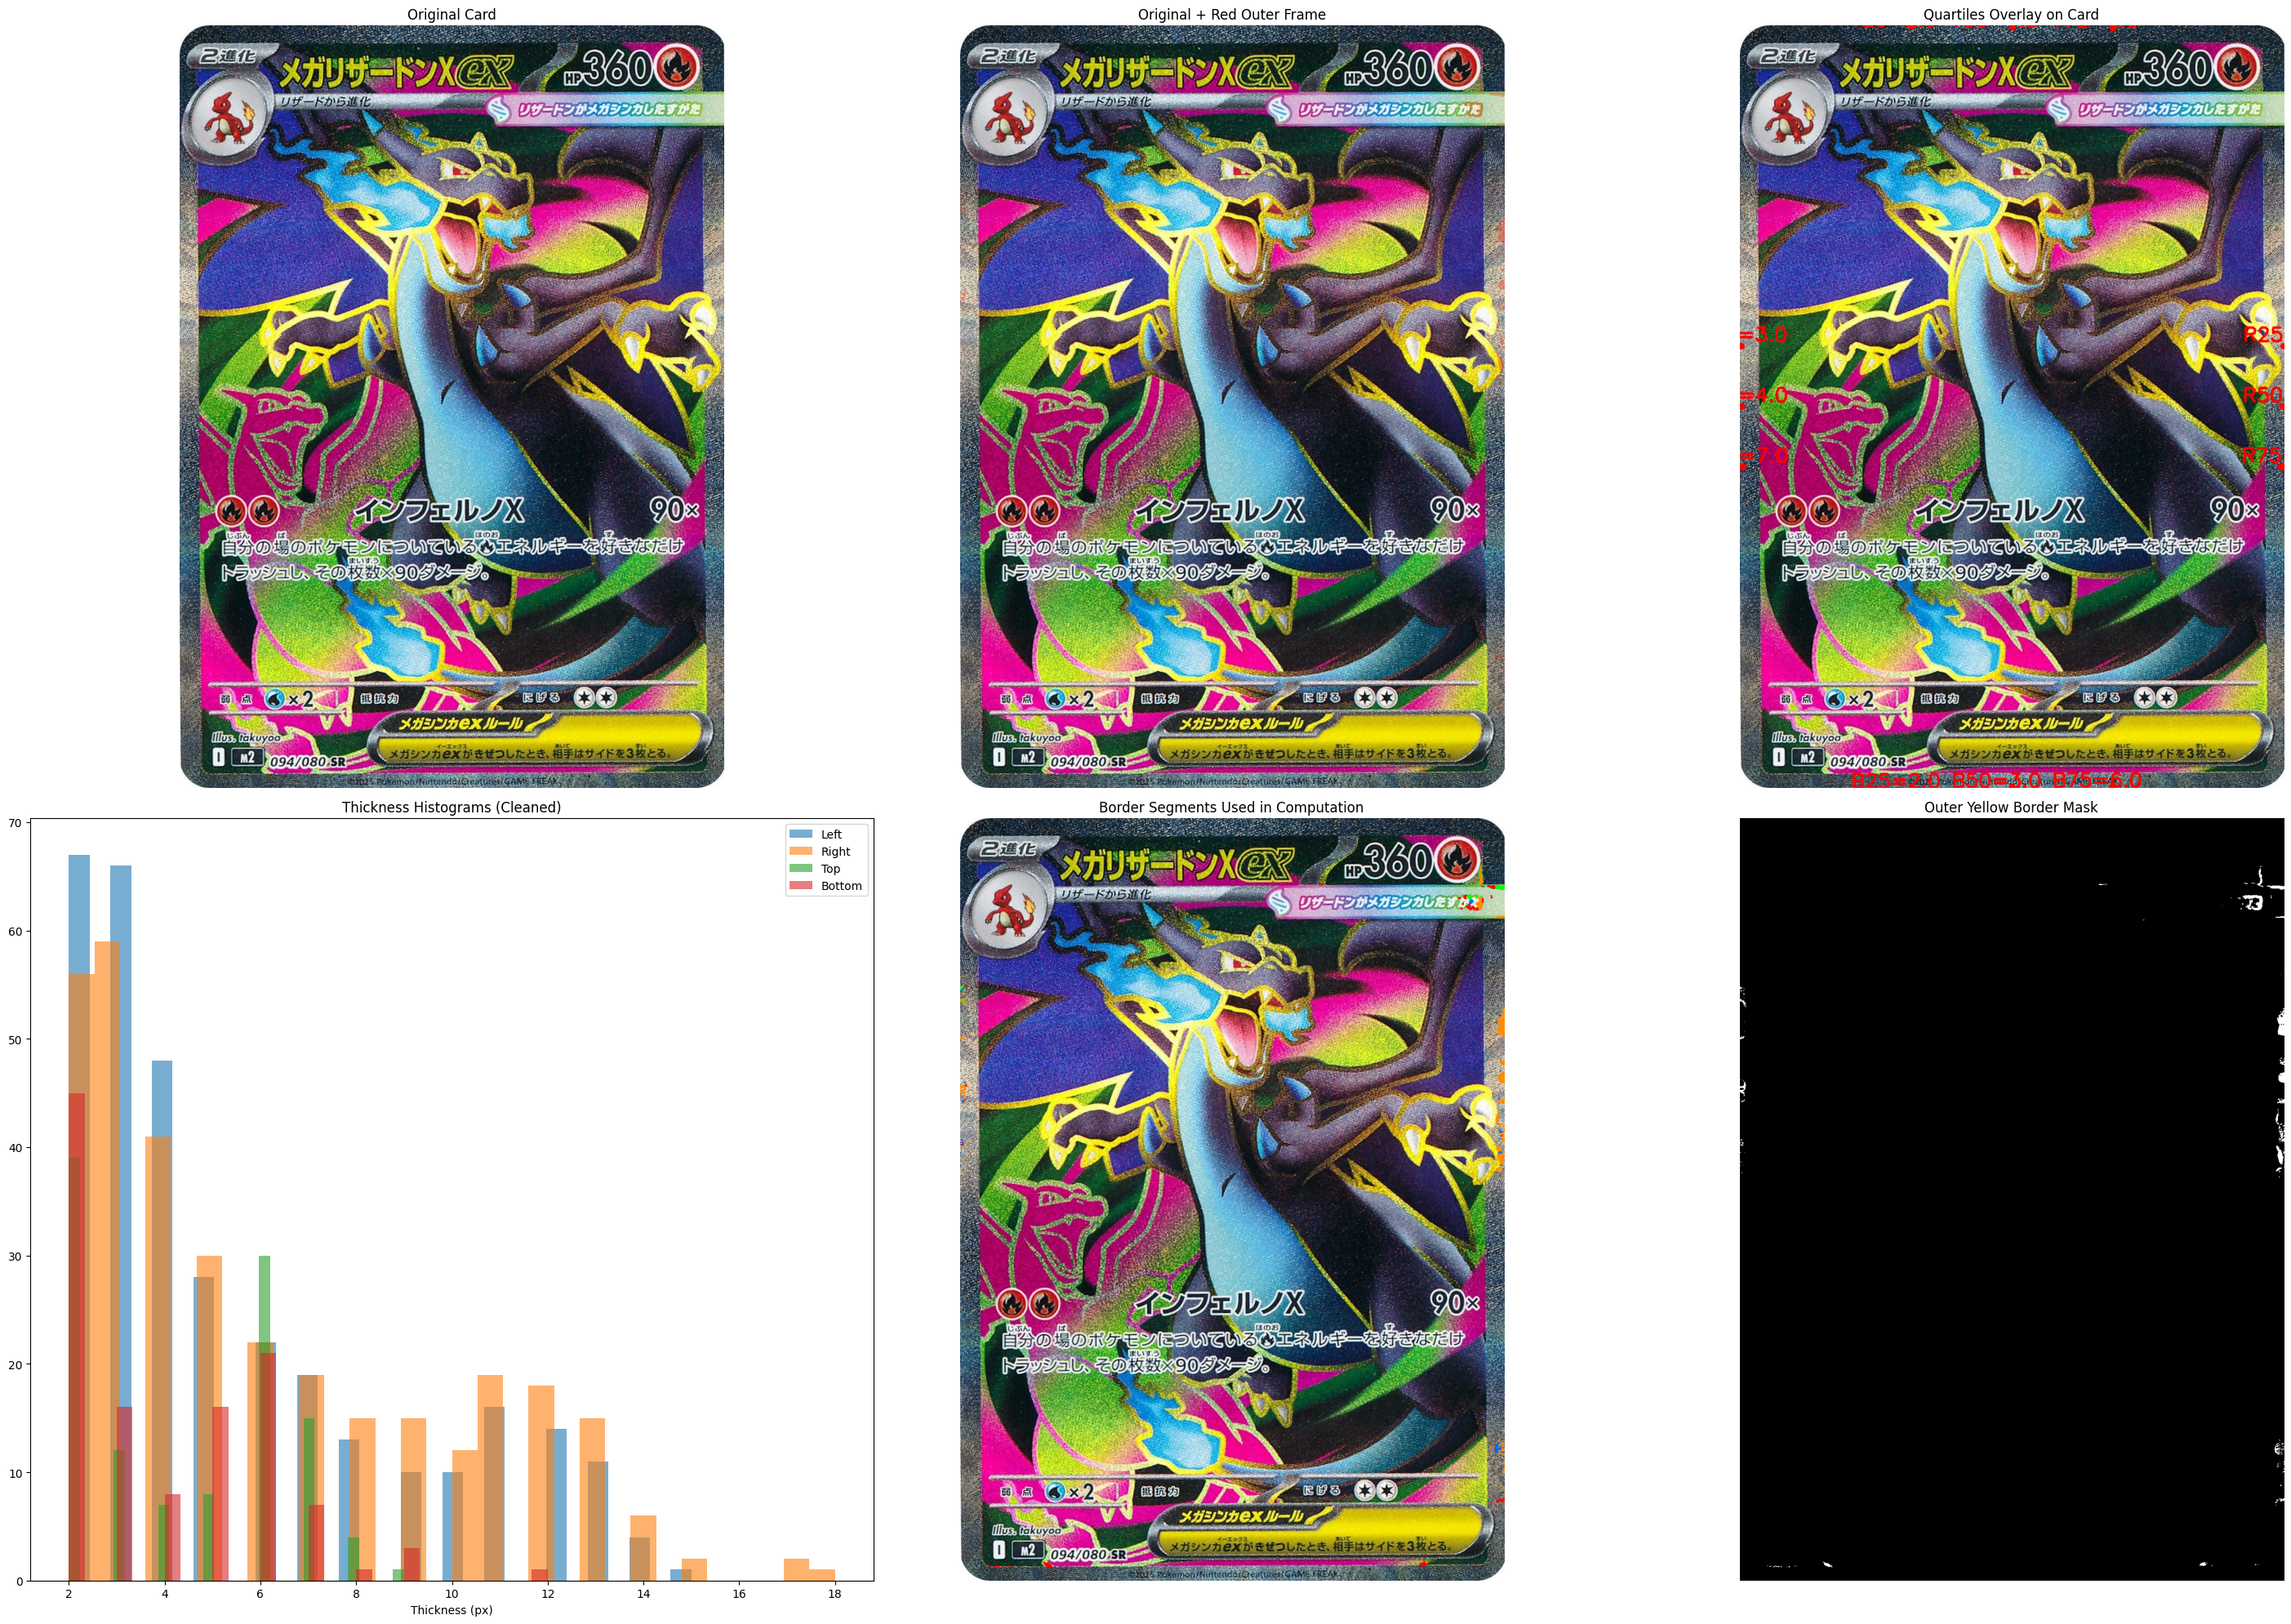

{'centering_LR': 0.4444444444444444,
 'centering_TB': 0.6,
 'quartiles': {'left': [3.0, 4.0, 7.0],
  'right': [3.0, 5.0, 9.0],
  'top': [2.0, 4.5, 6.0],
  'bottom': [2.0, 3.0, 6.0]}}

In [28]:
import cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ===========================
# LOAD IMAGE
# ===========================
img_path = "m-charizard-x.webp"   # adjust if needed
pil = Image.open(img_path).convert("RGB")
img = np.array(pil)
H, W = img.shape[:2]


# ===========================
# 1. CARD SILHOUETTE (GEOMETRIC)
# ===========================
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
edges = cv2.Canny(blur, 50, 150)
edges_dil = cv2.dilate(edges, np.ones((5,5), np.uint8))

card_contours, _ = cv2.findContours(edges_dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
card_cnt = max(card_contours, key=cv2.contourArea)

card_mask = np.zeros((H, W), dtype=np.uint8)
cv2.drawContours(card_mask, [card_cnt], -1, 255, thickness=cv2.FILLED)


# ===========================
# 2. OUTER YELLOW DETECTION (COLOR MASK)
# ===========================
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_y = np.array([15, 40, 40])
upper_y = np.array([45, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_y, upper_y)


# ===========================
# 3. EXTRACT ONLY YELLOW NEAR CARD EDGE (DISTANCE TRANSFORM)
# ===========================
card_bin = (card_mask > 0).astype(np.uint8)
dist = cv2.distanceTransform(card_bin, cv2.DIST_L2, 5)

max_outer_strip = 10   # max distance from edge to consider as outer frame
outer_strip = (dist <= max_outer_strip).astype(np.uint8) * 255

# FINAL OUTER BORDER MASK (B2b-style)
ring_raw = cv2.bitwise_and(yellow_mask, outer_strip)
ring_bool = (ring_raw == 255)


# ===========================
# 4. BORDER THICKNESS PROFILES (also store segment coordinates)
# ===========================

# Initialize segment coordinate arrays
left_seg   = [None] * H   # (x_start, x_end) for left border
right_seg  = [None] * H   # (x_start, x_end) for right border
top_seg    = [None] * W   # (y_start, y_end) for top border
bottom_seg = [None] * W   # (y_start, y_end) for bottom border

# ---- Horizontal profiles (rows) -----------------------------------
left_prof  = []
right_prof = []

for y in range(H):
    row = ring_bool[y]
    idx = np.where(row)[0]

    if len(idx) == 0:
        left_prof.append(0)
        right_prof.append(0)
        left_seg[y]  = None
        right_seg[y] = None
        continue

    # LEFT contiguous segment
    L_start = idx[0]
    L_end   = L_start
    for i in range(L_start+1, W):
        if row[i]: L_end = i
        else: break

    thickness_left = L_end - L_start + 1
    left_prof.append(thickness_left)
    left_seg[y] = (L_start, L_end)

    # RIGHT contiguous segment
    R_start = idx[-1]
    R_end   = R_start
    for i in range(R_start-1, -1, -1):
        if row[i]: R_end = i
        else: break

    thickness_right = R_start - R_end + 1
    right_prof.append(thickness_right)
    right_seg[y] = (R_end, R_start)


# ---- Vertical profiles (columns) -----------------------------------
top_prof    = []
bottom_prof = []

for x in range(W):
    col = ring_bool[:, x]
    idx = np.where(col)[0]

    if len(idx) == 0:
        top_prof.append(0)
        bottom_prof.append(0)
        top_seg[x]    = None
        bottom_seg[x] = None
        continue

    # TOP contiguous segment
    T_start = idx[0]
    T_end   = T_start
    for j in range(T_start+1, H):
        if col[j]: T_end = j
        else: break

    thickness_top = T_end - T_start + 1
    top_prof.append(thickness_top)
    top_seg[x] = (T_start, T_end)

    # BOTTOM contiguous segment
    B_start = idx[-1]
    B_end   = B_start
    for j in range(B_start-1, -1, -1):
        if col[j]: B_end = j
        else: break

    thickness_bottom = B_start - B_end + 1
    bottom_prof.append(thickness_bottom)
    bottom_seg[x] = (B_end, B_start)

# Convert profiles to numpy arrays
left_prof   = np.array(left_prof,   dtype=float)
right_prof  = np.array(right_prof,  dtype=float)
top_prof    = np.array(top_prof,    dtype=float)
bottom_prof = np.array(bottom_prof, dtype=float)


# ===========================
# 5. REMOVE OUTLIERS
# ===========================
def mask_clean(a):
    """
    Returns a boolean mask selecting valid + non-outlier thickness values.
    Steps:
        1. Remove values <= 1  (invalid)
        2. Compute IQR threshold on valid values only
        3. Combine masks
    Returns:
        mask (boolean array aligned to original 'a')
    """

    # Step 1: validity mask (remove zeros/ones)
    mask_valid = (a > 1)

    # Extract only valid values
    valid_vals = a[mask_valid]
    if len(valid_vals) == 0:
        return np.zeros_like(a, dtype=bool)

    # Step 2: Compute IQR on valid values only
    Q1 = np.percentile(valid_vals, 25)
    Q3 = np.percentile(valid_vals, 75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    # Step 3: IQR filter on the full array
    mask_iqr = (a >= low) & (a <= high)

    # Final combined mask
    return mask_valid & mask_iqr

# Clean masks
mask_left   = mask_clean(left_prof)
mask_right  = mask_clean(right_prof)
mask_top    = mask_clean(top_prof)
mask_bottom = mask_clean(bottom_prof)

# Apply masks
left_f   = left_prof[mask_left]
right_f  = right_prof[mask_right]
top_f    = top_prof[mask_top]
bottom_f = bottom_prof[mask_bottom]


# ===========================
# 6. QUARTILES
# ===========================
def three(a):
    a = np.array(a)
    return float(np.percentile(a,25)), float(np.median(a)), float(np.percentile(a,75))

L25,L50,L75 = three(left_f)
R25,R50,R75 = three(right_f)
T25,T50,T75 = three(top_f)
B25,B50,B75 = three(bottom_f)


# ===========================
# 7. PSA-STYLE CENTERING
# ===========================
center_lr = L50 / (L50 + R50)
center_tb = T50 / (T50 + B50)


# ===========================
# 8. BORDER SEGMENTS TAKEN INTO ACCOUNT
# ===========================
# --- Draw segments with side-specific colors ---
border_segments_overlay = img.copy()

blue   = (0, 100, 255)   # left
orange = (255,140,0)     # right
green  = (0,255,0)       # top
red    = (255,0,0)       # bottom

# LEFT (blue)
for y in np.where(mask_left)[0]:
    seg = left_seg[y]
    if seg is not None:
        x0, x1 = seg
        cv2.line(border_segments_overlay, (x0, y), (x1, y), blue, 2)

# RIGHT (orange)
for y in np.where(mask_right)[0]:
    seg = right_seg[y]
    if seg is not None:
        x0, x1 = seg
        cv2.line(border_segments_overlay, (x0, y), (x1, y), orange, 2)

# TOP (green)
for x in np.where(mask_top)[0]:
    seg = top_seg[x]
    if seg is not None:
        y0, y1 = seg
        cv2.line(border_segments_overlay, (x, y0), (x, y1), green, 2)

# BOTTOM (red)
for x in np.where(mask_bottom)[0]:
    seg = bottom_seg[x]
    if seg is not None:
        y0, y1 = seg
        cv2.line(border_segments_overlay, (x, y0), (x, y1), red, 2)


# ===========================
# 9. ANNOTATED CARD WITH QUARTILES
# ===========================
annot = img.copy()

def draw_h(y, x0, x1, label):
    cv2.line(annot, (x0,y), (x1,y), (255,0,0), 12)
    cv2.putText(annot, label, ((x0+x1)//2 - 80, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255,0,0), 4)

def draw_v(x, y0, y1, label):
    cv2.line(annot, (x,y0), (x,y1), (255,0,0), 12)
    cv2.putText(annot, label, (x-120, (y0+y1)//2),
                cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255,0,0), 4)

# LEFT
draw_h(H//2-120, 0, int(L25), f"L25={L25:.1f}")
draw_h(H//2,     0, int(L50), f"L50={L50:.1f}")
draw_h(H//2+120, 0, int(L75), f"L75={L75:.1f}")

# RIGHT
draw_h(H//2-120, W-int(R25), W, f"R25={R25:.1f}")
draw_h(H//2,     W-int(R50), W, f"R50={R50:.1f}")
draw_h(H//2+120, W-int(R75), W, f"R75={R75:.1f}")

# TOP
draw_v(W//2-200, 0, int(T25), f"T25={T25:.1f}")
draw_v(W//2,     0, int(T50), f"T50={T50:.1f}")
draw_v(W//2+200, 0, int(T75), f"T75={T75:.1f}")

# BOTTOM
draw_v(W//2-200, H-int(B25), H, f"B25={B25:.1f}")
draw_v(W//2,     H-int(B50), H, f"B50={B50:.1f}")
draw_v(W//2+200, H-int(B75), H, f"B75={B75:.1f}")


# ===========================
# 10. RED FRAME OVERLAY ON ORIGINAL IMAGE
# ===========================
overlay_red = img.copy().astype(float)
overlay_red[ring_raw == 255] = (
    overlay_red[ring_raw == 255] * 0.7 +
    np.array([255, 0, 0]) * 0.3
)
overlay_red = np.clip(overlay_red, 0, 255).astype(np.uint8)


# ===========================
# 11. FINAL MULTI-PANEL FIGURE
# ===========================
fig,axs = plt.subplots(2,3,figsize=(30,20))

# Top row
axs[0,0].imshow(img)
axs[0,0].set_title("Original Card")
axs[0,0].axis("off")

axs[0,1].imshow(overlay_red)
axs[0,1].set_title("Original + Red Outer Frame")
axs[0,1].axis("off")

axs[0,2].imshow(annot)
axs[0,2].set_title("Quartiles Overlay on Card")
axs[0,2].axis("off")

# Bottom row
axs[1,0].hist(left_f,  bins=30, alpha=0.6, label="Left")
axs[1,0].hist(right_f, bins=30, alpha=0.6, label="Right")
axs[1,0].hist(top_f,   bins=30, alpha=0.6, label="Top")
axs[1,0].hist(bottom_f,bins=30, alpha=0.6, label="Bottom")
axs[1,0].legend()
axs[1,0].set_title("Thickness Histograms (Cleaned)")
axs[1,0].set_xlabel("Thickness (px)")

axs[1,1].imshow(border_segments_overlay)
axs[1,1].set_title("Border Segments Used in Computation")
axs[1,1].axis("off")

axs[1,2].imshow(ring_raw, cmap='gray')
axs[1,2].set_title("Outer Yellow Border Mask")
axs[1,2].axis("off")

plt.tight_layout()
plt.show()

{
 "centering_LR": center_lr,
 "centering_TB": center_tb,
 "quartiles": {
     "left":[L25,L50,L75],
     "right":[R25,R50,R75],
     "top":[T25,T50,T75],
     "bottom":[B25,B50,B75]
 }
}

In [29]:
print("Final Centering Left/Right:", f"{round(center_lr*100,1)}%")
print("Final Centering Top/Bottom:", f"{round(center_tb*100,1)}%")

Final Centering Left/Right: 44.4%
Final Centering Top/Bottom: 60.0%
